In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [4]:
import pandas as pd
import numpy as np
np.random.seed(42)

In [5]:
n_assets = 50
n_days = 365
dates = pd.date_range('2025-01-01', periods=n_days)

data = []

In [6]:
for asset_id in range(1, n_assets+1):
    for date in dates:
        # Normal patterns
        cpu_mean = np.random.normal(35, 10, 1)[0]
        ram_mean = np.random.normal(45, 15, 1)[0]
        disk_usage = np.random.normal(70, 20, 1)[0]
        logins = np.random.poisson(10)
        failed_logins = np.random.poisson(0.5)
        tickets = np.random.poisson(0.3)
        network_mb = np.random.normal(500, 200, 1)[0]
        
        # Inject anomalies (5% of days)
        if np.random.random() < 0.05:
            cpu_mean *= 1.8  # CPU spike
            failed_logins *= 5
            tickets *= 3
            incident = 1
        else:
            incident = 0
            
        data.append({
            'asset_id': asset_id,
            'date': date,
            'cpu_mean': max(0, cpu_mean),
            'ram_mean': max(0, ram_mean),
            'disk_usage': min(100, max(0, disk_usage)),
            'logins': logins,
            'failed_logins': failed_logins,
            'tickets_opened': tickets,
            'network_mb': network_mb,
            'incident': incident
        })

In [7]:
df = pd.DataFrame(data)
df.to_csv("../data/asset_metrics.csv", index=False)

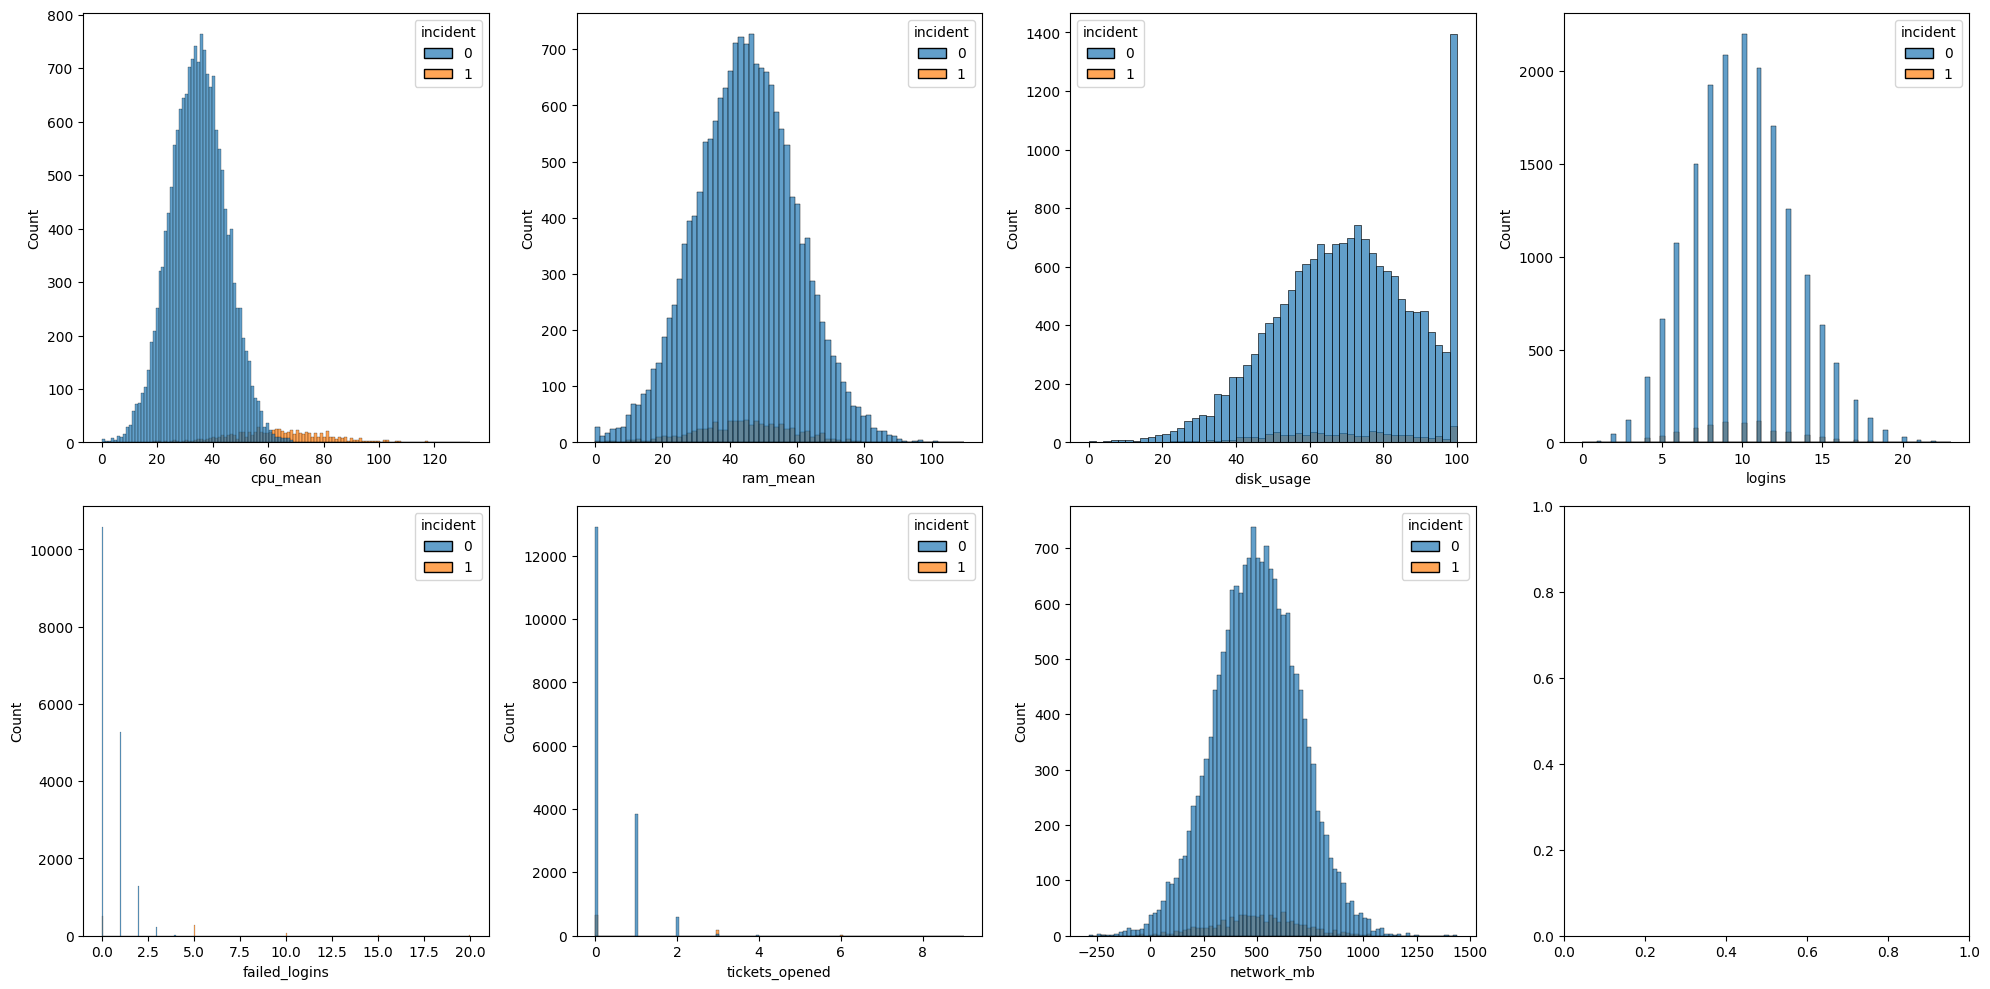

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, col in enumerate(['cpu_mean', 'ram_mean', 'disk_usage', 'logins', 'failed_logins', 'tickets_opened', 'network_mb']):
    sns.histplot(data=df, x=col, hue='incident', ax=axes[i//4, i%4], alpha=0.7)
plt.tight_layout()
plt.savefig('../eda_normal_vs_anomalous.png')
plt.show()

In [14]:
from src.data_prep import load_and_preprocess, FEATURES
from src.model import train_model
X, scaler, df = load_and_preprocess('../data/asset_metrics.csv')
# Use first 80% for training (mostly normal)
X_train = X[df['incident'] == 0][:int(0.8*len(X))]
model = train_model(X_train)

✅ Dirs ready in: c:\Users\REZKI\Desktop\IT ASSET ANOMALY
Loaded (18250, 10) rows
✅ Scaler saved: c:\Users\REZKI\Desktop\IT ASSET ANOMALY\models\scaler.joblib
Epoch 0, Loss: 0.8553
Epoch 20, Loss: 0.8372
Epoch 40, Loss: 0.8243
Epoch 60, Loss: 0.8062
Epoch 80, Loss: 0.7706
✅ Model saved to models/anomaly_model.pt


In [15]:
# Time-based split (realistic)
split_idx = int(0.8 * len(X))
X_train_all, X_test = X[:split_idx], X[split_idx:]
y_train_all, y_test = df['incident'].iloc[:split_idx].values, df['incident'].iloc[split_idx:].values

# Training data: mostly normal (remove known incidents)
train_normal_mask = y_train_all == 0
X_train = X_train_all[train_normal_mask]
print(f"Train normal: {X_train.shape}, Test: {X_test.shape} ({y_test.sum()} incidents)")


Train normal: (13928, 7), Test: (3650, 7) (177 incidents)


In [18]:
from src.model import train_model
model = train_model(X_train)  # Convert to numpy if needed
print("✅ Model trained and saved!")

Epoch 0, Loss: 0.8362
Epoch 20, Loss: 0.8293
Epoch 40, Loss: 0.8214
Epoch 60, Loss: 0.8094
Epoch 80, Loss: 0.7876
✅ Model saved to models/anomaly_model.pt
✅ Model trained and saved!
